In [ ]:
# -*- coding: utf-8 -*-
#  Copyright 2023 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by: Mariam Demir, Maike Meier

## Memory and Performance Profiling CIL Algorithms: CGLS vs. LSQR 

In [1]:
import sys
sys.path.append(".")

from LSQR import *
from LSQR_Tikhonov import *

from LSQRLP import *
from LSQRMP import *

from CGLSLP import *
from CGLSMP import *

# CIL core components needed
from cil.io import TIFFStackReader
from cil.processors import Normaliser, TransmissionAbsorptionConverter, Padder, CentreOfRotationCorrector, Slicer
from cil.framework import ImageGeometry, AcquisitionGeometry, AcquisitionData, BlockDataContainer

# CIL optimisation algorithms and linear operators
from cil.optimisation.algorithms import CGLS
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator, FiniteDifferenceOperator

# CIL example synthetic test image
from cil.utilities.dataexample import SHAPES
from cil.utilities import dataexample
from cil.utilities.jupyter import islicer

# CIL display tools
from cil.utilities.display import show2D, show1D, show_geometry

# CIL FBP
from cil.recon import FBP

# Forward/backprojector from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# Third-party imports
import numpy as np    
import scipy
import os
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import re

MB = 1/(1024*1024)
dtypeSize = 4

In [2]:
# Functions to process the outputs:

def mem_prof_process(output, norm=False):
    mem_prof = output.stdout

    # split text into lines
    blocks = re.split(r"Filename: .+", mem_prof)[1:]
    pattern = r"\s*(\d+)\s+([\d.]*){1}(\s*MiB\s*){1}(-?[\d.]+){1}(\s*MiB\s*){1}(\d+){1}(\s+.*)"
    repNum = None
   
    for idx, block in enumerate(blocks):
        # split the string into lines
        lines = block.split('\n')    
        memusages = []
            
        # iterate over each line/string
        for line in lines:          
            memUsgMatch = re.match(pattern, line)
            funcNmMatch = re.match(r"\s*(\d+)\s*(def (.+)\(.*)", line)
            
            if funcNmMatch:
                funcName = funcNmMatch.group(2)
                method = funcNmMatch.group(3)
                if method == "update":
                    rearr=True
                if repNum is not None:
                    method = f"{method} {repNum}"

            if memUsgMatch:
                memusages.append(float(memUsgMatch.group(2)))

            repMatch = re.match(r"(\w+) (\d+)", line)
            if repMatch:
                repNum = repMatch.group(2)

        blocks[idx] = [method, funcName.strip('\r'), memusages[0], memusages[-1]]
    
    rearrBlocks = list(reversed(blocks[:2]))
    currGroup = []
    for i, item in enumerate(blocks[2:]):
        method = item[0]
    
        repNumMatch = re.match(r'\w+ (\d+)', method)
        if repNumMatch:
            repNum = int(repNumMatch.group(1))
    
            if not currGroup:
                currGroup.append(item)
                
            elif repNum == int(re.search(r'\w+ (\d+)', currGroup[-1][0]).group(1)):
                currGroup.append(item)
            else:
                rearrBlocks.extend(list(reversed(currGroup)))
                currGroup = [item]
            if i == len(blocks[2:])-1:
                rearrBlocks.extend(list(reversed(currGroup)))       
        else:
            rearrBlocks.append(item)

    mp_df = DataFrame(rearrBlocks, columns=['Method', 'Method Call', 'Initial Memory Usage (MiB)', 'Final Memory Usage (MiB)'])
    if norm:
        mp_df = normalise_df(mp_df)
    mp_df['Total Memory Usage (MiB)'] = mp_df['Final Memory Usage (MiB)'] - mp_df['Initial Memory Usage (MiB)']

    return mp_df

def line_prof_process(output, norm=False):
    line_prof = output.stdout
    df = {'Method': ['init', 'setup'], 'Initial Memory Usage (MiB)': [], 'Final Memory Usage (MiB)': []}
    memory_usage = {'init': [], 'setup': [], 'run': []}
    countrun = 1

    for res in line_prof.splitlines():
        match = re.match(r"(\w+) of (\w+).+ ([0-9]+\.[0-9]+).+", res)
        if match:
            action, method, value = match.groups()
            value = float(value)

            if action == 'Start' and method =='run' and method not in df['Method']:
                df['Method'].append(f"{method} {countrun}")
                countrun += 1

            if method.startswith('run'):
                memory_usage['run'].append(value)
            elif method in memory_usage:
                memory_usage[method].append(value)

    # Populate initial and final memory usage
    df['Initial Memory Usage (MiB)'] = [memory_usage['init'][0], memory_usage['setup'][0]] + memory_usage['run'][::2]
    df['Final Memory Usage (MiB)'] = [memory_usage['init'][1], memory_usage['setup'][1]] + memory_usage['run'][1::2]

    lp_df = DataFrame(df)
    if norm:
        lp_df = normalise_df(lp_df)
    lp_df['Total Memory Usage (MiB)'] = lp_df['Final Memory Usage (MiB)'] - lp_df['Initial Memory Usage (MiB)']
    
    return lp_df

def normalise_df(df):
    # Access the start memory from the "init" method
    startMem = df["Initial Memory Usage (MiB)"].iat[0]
    # subtract startMem from all values in the df
    df[df.select_dtypes(include=['number']).columns] -= startMem # Done BEFORE computing Total Mem Usg

    return df 

def split_groups(line_prof_peak):
    pattern = r"(\w+) of (\w+).+ ([0-9]+\.[0-9]+).+"
    groups = {}
    stack = []
    methodrep = None
    
    for line in line_prof_peak.splitlines():
        repmatch = re.match(r"(^\w*) ([0-9]+$)", line)
        if repmatch: # Find repetitions of methods i.e. run/update
            methodrep = (repmatch.group(1), repmatch.group(2))   

        match = re.match(pattern, line) # Find line-by-line outputs
        if match:
            action, method, value = match.groups()
            value = float(value)
            if methodrep:
                method = f"{method} {methodrep[1]}"

            if action == "Start": # Stores new method encounter & adds to top of stack
                groups[method] = []
                stack.append(method)
                groups[method].append(line)
            elif action == "End": # Remove current method from top of stack
                groups[method].append(line)
                stack.pop(-1)

        elif stack: # Put all lines with the method on top of stack
            method = stack[-1]
            groups[method].append(line)
            if line.startswith("Memory Usage Log"): # Add background/peak memory lines to parent & child methods' group
                for parent_method in stack[:-1]: 
                    groups[parent_method].append(line)
            
    return groups

def line_peak_process(output, norm=False):
    line_prof_peak = output.stdout
    df = {'Method': [], 'Initial Memory Usage (MiB)': [], 'Peak Memory': [], 'Final Memory Usage (MiB)': [], 'Peak Line': []}
    groups = split_groups(line_prof_peak)
    pattern = r"(\w+) of (\w+).+ ([0-9]+\.[0-9]+).+"
    
    for method, block in groups.items():  # iterate over keys [init, start, run1, update1, run2, update2 ...]
        peakline = ""
        awaiting_line = True
        methodpeak = 0
        r = re.compile(pattern) # Get start and end memory usages for current method's block
        start, end = list(filter(r.match, block))
        startmem = float(re.match(pattern, start).group(3))
        endmem = float(re.match(pattern, end).group(3))

        df['Method'].append(method)
        df['Initial Memory Usage (MiB)'].append(startmem)
        df['Final Memory Usage (MiB)'].append(endmem)

        for line in block: # Find peak memory usage in current block 
            peakmatch = re.match(r".+ (\d+\.\d+)\s*MB.*", line)
            if peakmatch:
                currmem = float(peakmatch.group(1))
                if currmem > methodpeak:
                    methodpeak = currmem
                    awaiting_line = True

            codematch = re.match(r".+ \| Memory Usage: (\d+.\d+) MB \| line:(.+)+", line)
            if codematch: # Find the line-by-line output to attribute to the peak usage
                currmem = float(codematch.group(1))
                if currmem > methodpeak:
                    methodpeak = currmem
                    peakline = codematch.group(2).strip()
                    awaiting_line = False 
                elif awaiting_line:  
                    peakline = codematch.group(2).strip()
                    awaiting_line = False

        df['Peak Memory'].append(methodpeak)
        df['Peak Line'].append(peakline)

    df = DataFrame(df)
    if norm:
        df = normalise_df(df)
    df.insert(4, 'Total Memory Usage (MiB)', df['Final Memory Usage (MiB)']-df['Initial Memory Usage (MiB)'])
    df.insert(5, 'Peak Memory Increase (MiB)', df['Peak Memory']-df['Initial Memory Usage (MiB)'])
    
    return df

def plot_mem(dfs, algNms, norm=False, linestyles=("-", "--", "--")):

    plt.figure(figsize=(10, 6))

    for i, (df, algNm) in enumerate(zip(dfs, algNms)):
        df = df.iloc[::2]

        # Flatten data for sequential plotting
        methods = []
        stages = []
        values = []

        for _, row in df.iterrows():
            methods.extend([row["Method"]] * 3)
            stages.extend(["Initial", "Peak", "Final"])
            values.extend([row["Initial Memory Usage (MiB)"], row["Peak Memory"], row["Final Memory Usage (MiB)"]])

        if norm == True:
            startMem = df["Initial Memory Usage (MiB)"].iat[0]
            values = np.asarray(values) - startMem
            
        plt.plot(range(len(values)), values, label=algNm, marker="o", linestyle=linestyles[i])

    # x-axis method labels
    xticksPos = [i for i in range(len(values))]
    xticksLabels = [f"{method} - {stage}" for method, stage in zip(methods, stages)]

    plt.xticks(xticksPos, xticksLabels, rotation=60, ha="right", fontsize=10)

    # titles & labels
    plt.title(f"Memory Usage by Method (Sequential)", fontsize=14)
    plt.xlabel("Methods and Memory Stages", fontsize=12)
    plt.ylabel("Memory (MB)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)

    # highlight transitions between methods
    for i in range(0, len(values), 3):
        plt.axvline(i - 0.5, color="orange", linestyle="--", alpha=0.5)  # divider between methods

    plt.tight_layout()
    plt.legend()
    plt.show()

### Loading The Sandstone Dataset

In [3]:
dataexample.SANDSTONE.download_data(data_dir='.', prompt=False)

Dataset folder already exists in .


In [4]:
datapath = './sandstone'

filename = "slice_0270_data.mat"
all_data = scipy.io.loadmat(os.path.join(datapath,filename))

In [5]:
sandstone = all_data['X_proj'].astype(np.float32)
sandstone.shape

(2560, 1500)

In [6]:
ag = AcquisitionGeometry.create_Parallel2D()  \
         .set_panel(num_pixels=(2560))        \
         .set_angles(angles=np.linspace(0,180,1500,endpoint=False)) \
         .set_labels(['horizontal','angle'])
print(ag.dimension_labels)

sandstone = AcquisitionData(sandstone, geometry=ag, deep_copy=False)

(<AcquisitionDimension.HORIZONTAL: 'horizontal'>, <AcquisitionDimension.ANGLE: 'angle'>)


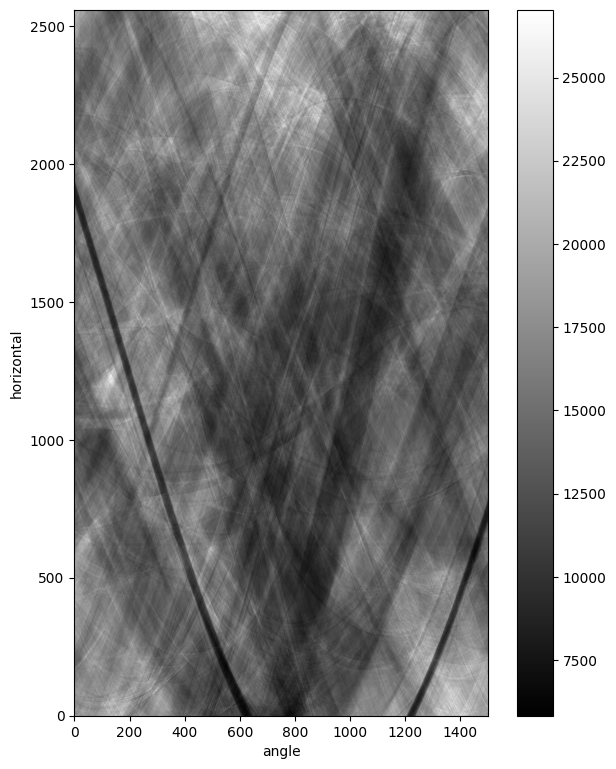

In [7]:
show2D(sandstone)

### Ground Truth - FBP Reconstruction of normalised sandstone

#### Flat and Dark Field Correction:

In [8]:
flats = all_data['X_flat'].astype(np.float32)
flats.shape

darks = all_data['X_dark'].astype(np.float32)
darks.shape

(2560, 30)

In [9]:
sandstone.reorder('astra')

In [10]:
sandstone_norm = Normaliser(flat_field=flats.mean(axis=1),
                   dark_field=darks.mean(axis=1))(sandstone)

sandstone_norm = TransmissionAbsorptionConverter()(sandstone_norm)

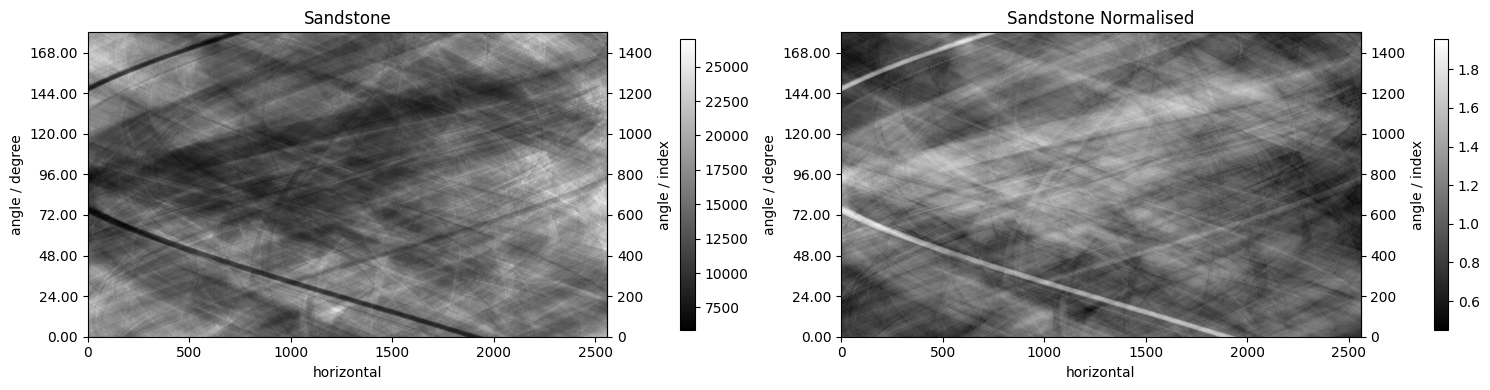

In [11]:
show2D([sandstone, sandstone_norm], title=['Sandstone', 'Sandstone Normalised'])

In [12]:
padsize = 600
sandstone_pad = Padder.edge(pad_width={'horizontal': padsize})(sandstone_norm)

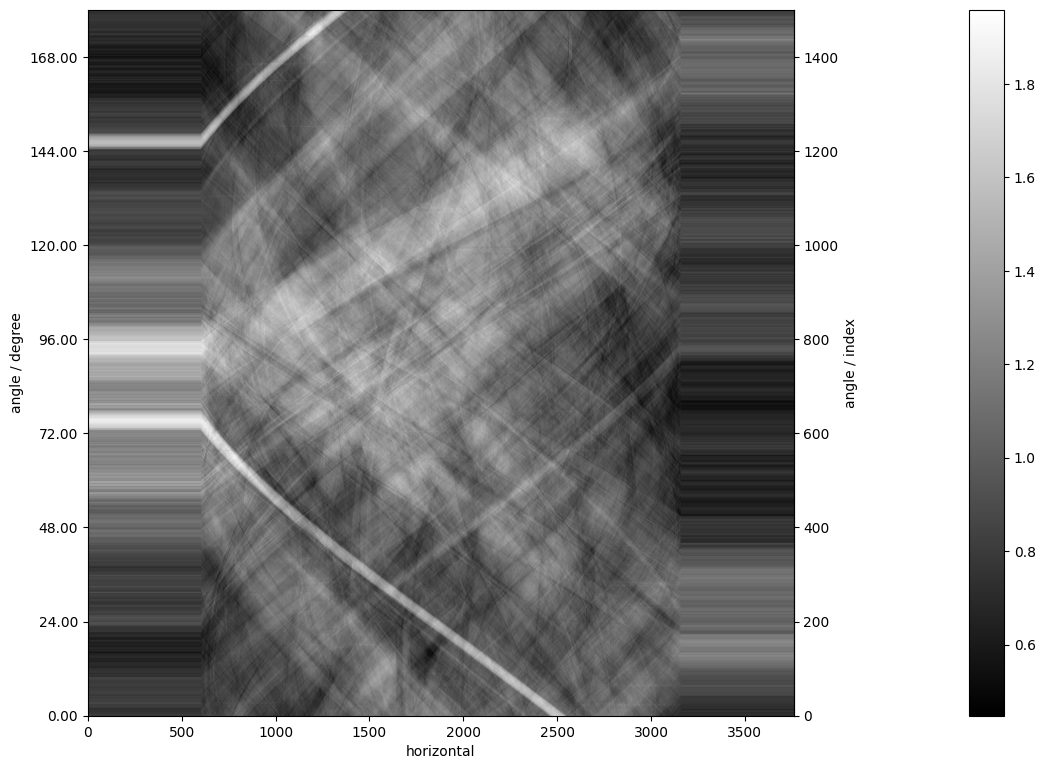

In [13]:
show2D(sandstone_pad)

In [14]:
sandstone_cor = CentreOfRotationCorrector.image_sharpness(backend='astra', search_range=100, tolerance=0.1)(sandstone_pad)
sandstone_cor.geometry.get_centre_of_rotation(distance_units='pixels')

{'offset': (44.48700388605622, 'pixels'), 'angle': (0.0, 'radian')}

In [15]:
ig = sandstone_norm.geometry.get_ImageGeometry()
recon = FBP(sandstone_cor, ig, backend='astra').run()

FBP recon

Input Data:
	angle: 1500
	horizontal: 3760

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



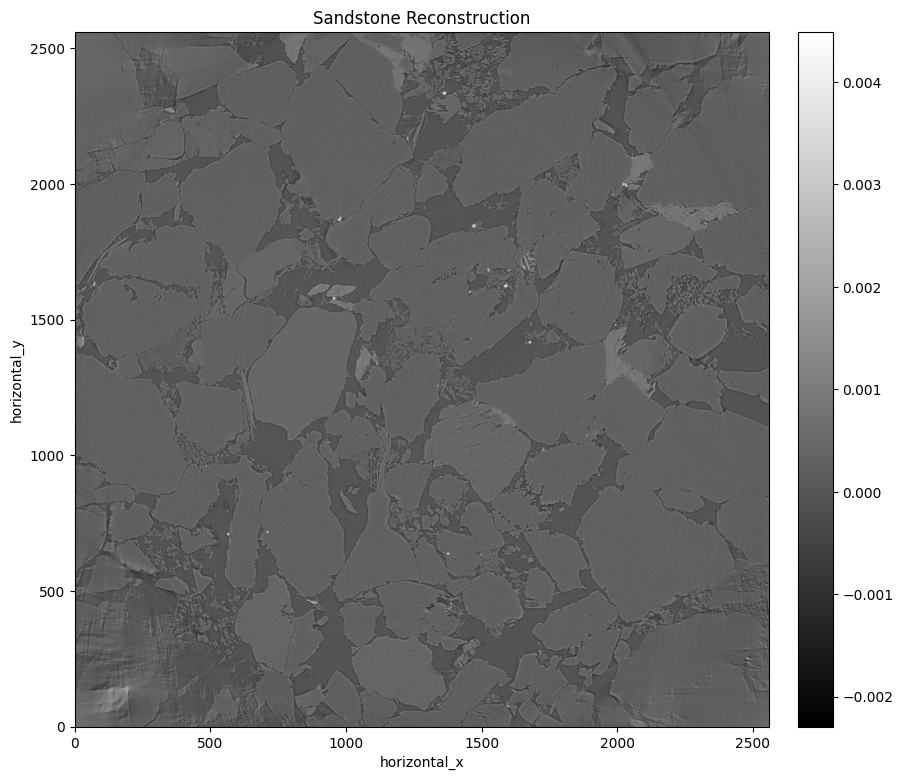

In [16]:
show2D(recon, title='Sandstone Reconstruction')

### Apply Noise:

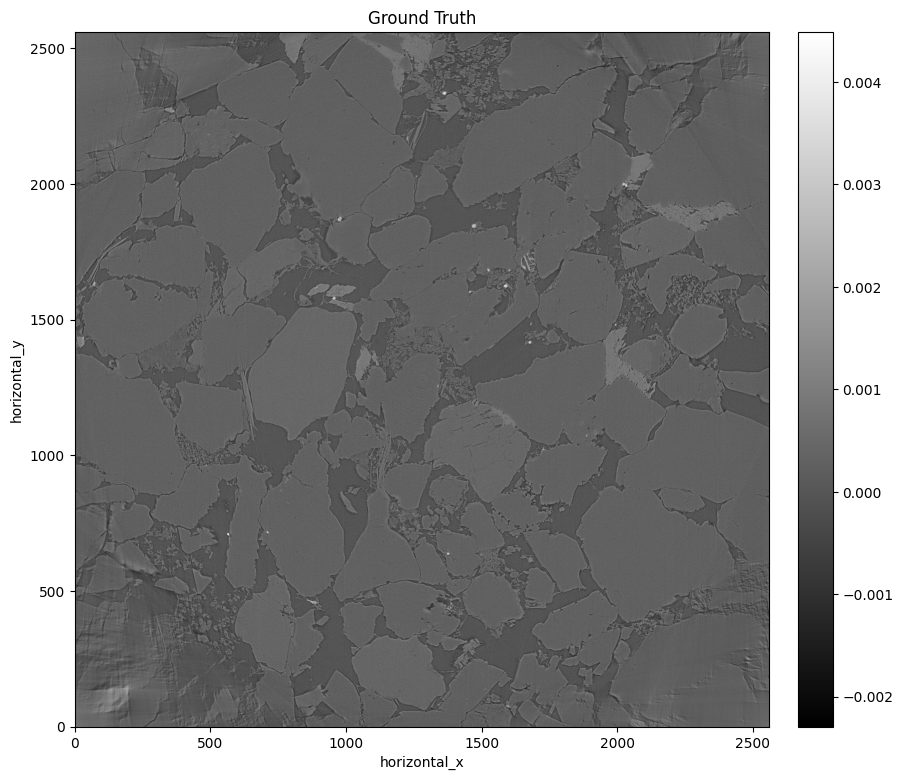

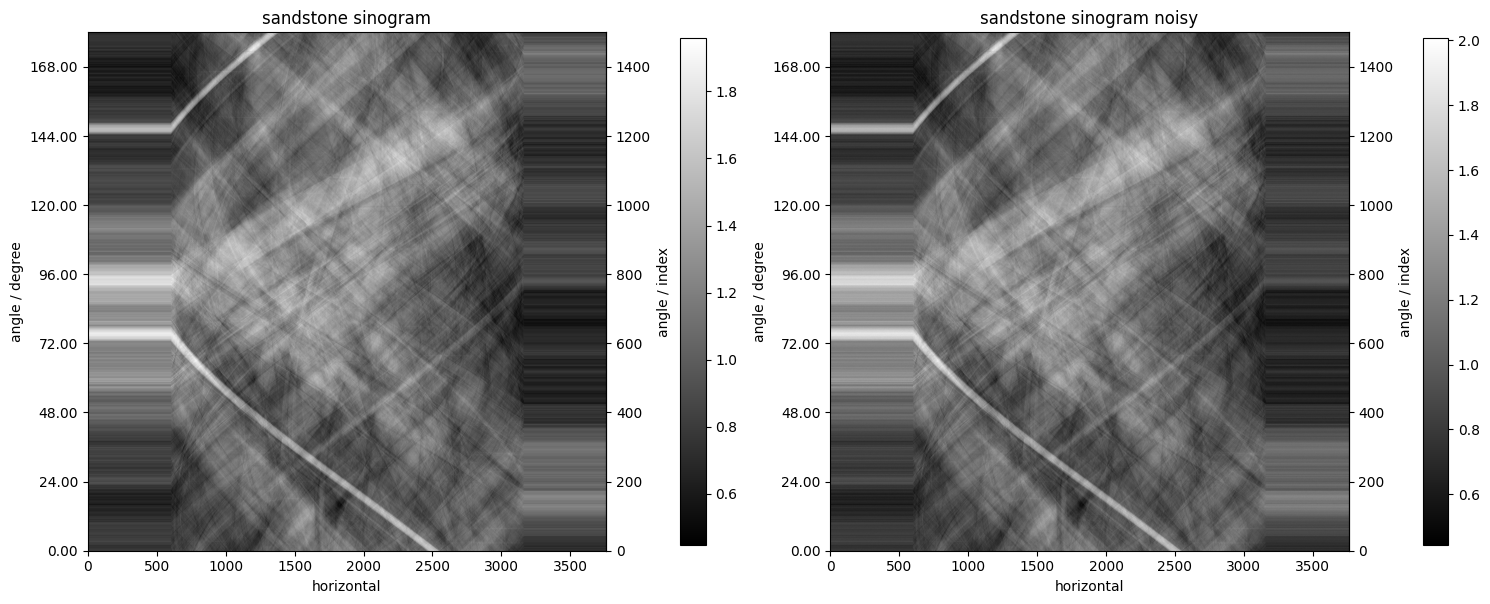

In [17]:
# Incident intensity: lower counts will increase the noise
background_counts = 10000

# Convert the simulated absorption sinogram to transmission values using Lambert-Beer. 
# Use sandstone_cor as mean for Poisson data generation.
# Convert back to absorption sinogram.
counts = background_counts * np.exp(-sandstone_cor.as_array())
noisy_counts = np.random.poisson(counts)
sand_noisy_data = -np.log(noisy_counts/background_counts)

# Create new AcquisitionData object with same geometry as sandstone_cor and fill with noisy data.
sandstone_noisy = sandstone_cor.geometry.allocate()
sandstone_noisy.fill(sand_noisy_data)
show2D(recon, title="Ground Truth")

plots = [sandstone_cor, sandstone_noisy]
titles = ["sandstone sinogram", "sandstone sinogram noisy"]
show2D(plots, titles)

### CGLS and LSQR without regularisation

Before describing Tikhonov regularisation, we recall the problem solved by LSQR:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}^2_2$$

where,

- $A$ is the projection operator

- $b$ is the acquired data

- $u$ is the unknown image to be determined

In the solution provided by LSQR the low frequency components tend to converge faster than the high frequency components. This means we need to control the number of iterations carefully to select the optimal solution.

Set up the LSQR algorithm, including specifying its initial point to start from:

In [25]:
sandstone_noisy.reorder('astra')
ig = sandstone_noisy.geometry.get_ImageGeometry()
ag = sandstone_noisy.geometry # ig and ag need to be same

device = "gpu"
A = ProjectionOperator(ig, ag, device)

padend= sandstone_noisy.shape[1]-padsize
roi = {'horizontal':(padsize, padend)}
roi_xy = {'horizontal_y':(padsize, padend), 'horizontal_x':(padsize, padend)}

initial = ig.allocate(0)

sino_norm = Slicer(roi)(sandstone_cor).norm() # crop the 'perfect' sinogram
recon_norm = recon.norm() # 'perfect' reconstruction, already cropped

maxit = 100
itsAtATime = 1
N = round(maxit/itsAtATime)

xx = np.arange(0, maxit, itsAtATime)

The `timed_iterations` function below will be used to run the algorithms in increments, so we can store the residuals, errors and time taken per iteration:

In [26]:
import time

def timed_iterations(algorithm, iterations, itsAtATime):
    times = np.zeros(iterations)
    residuals = np.zeros(iterations)
    errors = np.zeros(iterations)
    time_tot = 0
    
    for ii in range(iterations): 
        start = time.time()
        algorithm.run(itsAtATime, verbose=False)
        end = time.time()

        solutncrop = Slicer(roi_xy)(algorithm.solution)
        directcrop = Slicer(roi)(A.direct(algorithm.solution))
        sandstone_noisy_crop = Slicer(roi)(sandstone_noisy)
        
        residual = directcrop - sandstone_noisy_crop
        
        res_norm = residual.norm()
        rel_res = res_norm/sino_norm     
        residuals[ii] = rel_res

        # the solution needs to be cropped, recon is already cropped
        error = solutncrop - recon
        err_norm = error.norm()
        rel_err = err_norm/recon_norm
        errors[ii] = rel_err

        time_tot += end-start
        times[ii] = time_tot     
    # show2D([solutncrop, directcrop])
    return times, residuals, errors

Once set up, we can initialise and run the algorithms for the specified number of iterations:

In [ ]:
cgls_simple = CGLS(initial=initial, operator=A, data=sandstone_noisy)
times_cgls, rel_res_vec_cgls, rel_err_vec_cgls = timed_iterations(cgls_simple, N, itsAtATime)

lsqr_simple = LSQR(initial=initial, operator=A, data=sandstone_noisy)
times_lsqr, rel_res_vec_lsqr, rel_err_vec_lsqr = timed_iterations(lsqr_simple, N, itsAtATime)

#### Convergence/reduction of residuals:

The plots below show the progress of the residuals across each iteration, and the error across iterations:

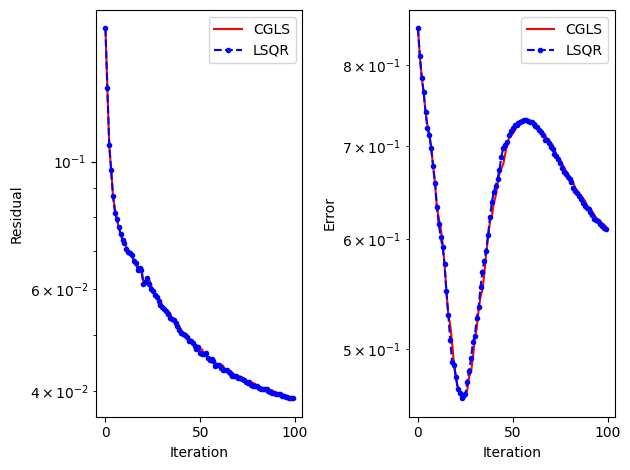

In [31]:
plt.subplot(1,2,1)
plt.semilogy(xx, rel_res_vec_cgls, 'r-', xx, rel_res_vec_lsqr, 'b.--')
plt.xlabel('Iteration') 
plt.ylabel('Residual') 
plt.gca().legend(('CGLS','LSQR'))

plt.subplot(1,2,2)
plt.semilogy(xx, rel_err_vec_cgls, 'r-', xx, rel_err_vec_lsqr, 'b.--')
plt.xlabel('Iteration') 
plt.ylabel('Error') 
plt.gca().legend(('CGLS','LSQR'))
plt.tight_layout()

We can also compare the time taken/elapsed across each iteration.  
For both algorithms, this relationship is linear. The time elapsed for the 100 iterations is faster for CGLS and LSQR.

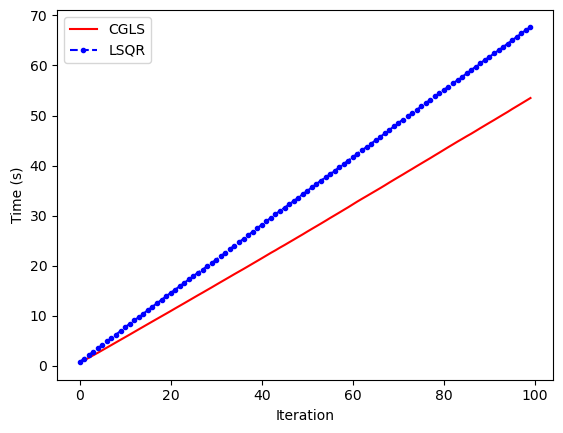

In [30]:
plt.plot(xx, times_cgls, 'r-', xx, times_lsqr, 'b.--')
plt.xlabel('Iteration') 
plt.ylabel('Time (s)')
plt.gca().legend(('CGLS','LSQR'))

### Memory Profiling

To profile the memory usage, a custom version of the CGLS file was created.
`CGLS_MP` uses the `memory_profiler` module to profile the `__init__, set_up and run` methods.  
To validate these results, `CGLS_LP` uses `psutil` to manually track the memory usage after each line in these methods. This version also tracks the memory usage in a separate thread, which shows the peak usages in each method. The same was done for LSQR.

Below, we will run the `memory-sandstone.py` script using the modified files, and analyse the outputs:

#### Validating Profiling Tools:

In [45]:
%%capture cgls_mem_prof
!python3 memory-sandstone.py cgls_mp

In [39]:
%%capture cgls_line_prof
!python3 memory-sandstone.py cgls_lp --track-peak

First, we can view the line-by-line memory increases from the `memory_profiler` output:

In [5]:
print(*cgls_mem_prof.stdout.splitlines()[:117], sep="\n") # Print set_up, __init__ & run 1

Dataset folder already exists in .
Filename: /home/efv97572/forks/CIL-User-Showcase/015_Memory_Profiling_LSQR_CGLS/CGLSMP.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    81   652.82 MiB   652.82 MiB           1       @profile(precision=2)
    82                                             def set_up(self, initial, operator, data):
    83                                                 r'''Initialisation of the algorithm
    84                                                 Parameters
    85                                                 ------------
    86                                                 operator : Operator
    87                                                     Linear operator for the inverse problem
    88                                                 initial : (optional) DataContainer in the domain of the operator, default is a DataContainer filled with zeros. 
    89                                                     Initial guess 
    

In [40]:
# ImageData and AcquisitionData Sizes
print(f"Estimate of 'initial' (ImageData) size: {initial.size*dtypeSize*MB}")
print(f"Estimate of 'sandstone_noisy' (AcquisitionData) size: {sandstone_noisy.size*dtypeSize*MB}")

Estimate of 'initial' (ImageData) size: 53.9306640625
Estimate of 'sandstone_noisy' (AcquisitionData) size: 21.514892578125


In the `set_up` method, we can see: 
* 3 increases of **~53.9 MB** - these correspond to the size of the **ImageData** space
* 2 increases of **~21.5 MB** - corresponding to the **AcquisitionData** space

These increases are expected. In the `__init__` method, the same increase is seen as a result of the call to `set_up`.
In each run, there is an increase in memory usage due to the iterable in line 158, which calls the `update` method.

For easier visualisation of the Initial and Final usages per method, we process this output and display it as a dataframe. The first usage reading is ~653 MB, which is the memory allocated when loading and processing the dataset. To show the memory usage of the CGLS algorithm alone, this dataframe has been normalised by subtracting the prior memory usage from the results:

In [50]:
cgls_mp = mem_prof_process(cgls_mem_prof, norm=True)
cgls_mp

,Method,Method Call,Initial Memory Usage (MiB),Final Memory Usage (MiB),Total Memory Usage (MiB)
0,__init__,"def __init__(self, initial=None, operator=None...",0.00,204.84,204.84
1,set_up,"def set_up(self, initial, operator, data):",0.00,204.84,204.84
2,run 1,"def run(self, iterations=None, callbacks: Opti...",204.84,205.17,0.33
3,run 2,"def run(self, iterations=None, callbacks: Opti...",205.17,205.38,0.21
4,run 3,"def run(self, iterations=None, callbacks: Opti...",205.38,205.50,0.12
5,run 4,"def run(self, iterations=None, callbacks: Opti...",205.50,205.59,0.09
6,run 5,"def run(self, iterations=None, callbacks: Opti...",205.59,205.74,0.15
7,run 6,"def run(self, iterations=None, callbacks: Opti...",205.74,205.63,-0.11
8,run 7,"def run(self, iterations=None, callbacks: Opti...",205.63,205.97,0.34
9,run 8,"def run(self, iterations=None, callbacks: Opti...",205.97,205.79,-0.18


Let's compare these values to the line-by-line profiling results:

In [51]:
cgls_lp = line_prof_process(cgls_line_prof, norm=True)
cgls_lp

,Method,Initial Memory Usage (MiB),Final Memory Usage (MiB),Total Memory Usage (MiB)
0,init,0.00,204.65,204.65
1,setup,0.01,204.65,204.64
2,run 1,204.84,205.32,0.48
3,run 2,205.32,205.40,0.08
4,run 3,205.40,205.30,-0.10
5,run 4,205.30,205.65,0.35
6,run 5,205.65,205.75,0.10
7,run 6,205.75,205.89,0.14
8,run 7,205.89,205.78,-0.11
9,run 8,205.78,206.11,0.33


As we can see, the major change in memory corresponding to `set_up` and `__init__` are the same, with minor variations in the memory usages of the `run` calls.

#### Peak Memory Usages:
We have validated the memory usage tracking using two techniques. For the remainder of the notebook, we will be using output snippets from both to illustrate memory changes.

With the line-by-line profiling technique, we can also take a look at the peak memory usages that were measured on a separate thread, and the corresponding calls:

In [62]:
cgls_lp = line_peak_process(cgls_line_prof, norm=True)
cgls_lp

,Method,Initial Memory Usage (MiB),Peak Memory,Final Memory Usage (MiB),Total Memory Usage (MiB),Peak Memory Increase (MiB),Peak Line
0,init,0.00,204.89,204.89,204.89,204.89,"self.set_up(initial=initial, operator=operator..."
1,setup,0.00,204.89,204.89,204.89,204.89,self.normx = self.x.norm()
2,run 1,204.89,258.92,205.10,0.21,54.03,update(self)
3,update 1,204.99,258.92,205.10,0.11,53.93,"self.operator.direct(self.p, out=self.q)"
4,run 2,205.30,259.17,205.19,-0.11,53.87,update(self)
5,update 2,205.30,259.17,205.19,-0.11,53.87,"self.operator.direct(self.p, out=self.q)"
6,run 3,205.19,259.30,205.30,0.11,54.11,update(self)
7,update 3,205.19,259.30,205.30,0.11,54.11,"self.operator.direct(self.p, out=self.q)"
8,run 4,205.30,259.43,205.59,0.29,54.13,update(self)
9,update 4,205.30,259.43,205.59,0.29,54.13,"self.operator.direct(self.p, out=self.q)"


This table shows that CGLS' `set_up` and `__init__` calls do not have a spike in memory that exceeds the final usage. However, during the runs, the `update(self)` call produces peak increases around the size of the ImageData space. This memory usage is transient, and is released by the time the call is finished.

Looking at the **Method**=`update` Peak lines, we can see the biggest peak is attributed to the line `self.operator.direct(self.p, out=self.q)`, which creates a copy of the ImageData space during its execution, and releases the memory after it has run.

Below, we visualise this by plotting the total memory increases and the peak memory increases as sequential line graphs:

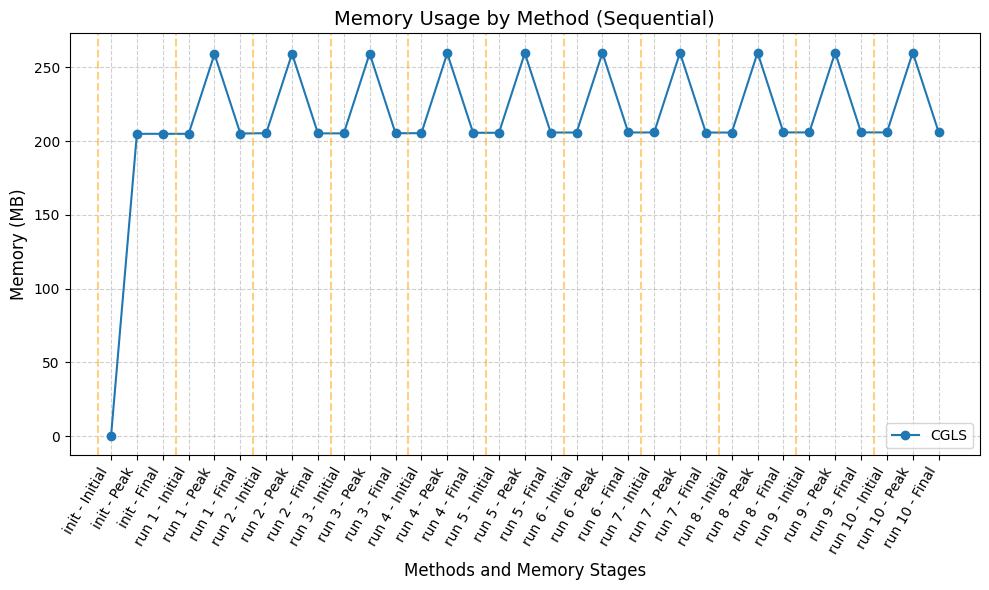

In [63]:
plot_mem((cgls_lp,), ("CGLS",))

#### Comparison With LSQR:
Let's compare this to LSQR's memory usage:

In [3]:
%%capture lsqr_line_prof
!python3 memory-sandstone.py lsqr_lp --track-peak

In [5]:
lsqr_lp = line_peak_process(lsqr_line_prof, norm=True)
lsqr_lp

,Method,Initial Memory Usage (MiB),Peak Memory,Final Memory Usage (MiB),Total Memory Usage (MiB),Peak Memory Increase (MiB),Peak Line
0,init,0.00,204.94,204.94,204.94,204.94,"self.set_up(initial=initial, operator=operator..."
1,setup,0.00,204.94,204.94,204.94,204.94,self.tmp_range = data.geometry.allocate(None)
2,run 1,204.94,259.33,259.33,54.39,54.39,update(self)
3,update 1,205.27,259.33,259.33,54.06,54.06,"self.d.sapyb(-theta/rho, self.v, 1, out=self.d)"
4,run 2,259.33,313.31,259.56,0.23,53.98,update(self)
5,update 2,259.33,313.31,259.55,0.22,53.98,"self.operator.direct(self.v, out=self.tmp_range)"
6,run 3,259.56,313.49,259.68,0.12,53.93,update(self)
7,update 3,259.56,313.49,259.68,0.12,53.93,"self.operator.direct(self.v, out=self.tmp_range)"
8,run 4,259.68,313.57,259.77,0.09,53.89,update(self)
9,update 4,259.68,313.57,259.77,0.09,53.89,"self.operator.direct(self.v, out=self.tmp_range)"


The table and plots show that LSQR has a **the same setup cost as CGLS**.
We also see the same Peak Increase in LSQR's `run` calls, again due to the ImageData copy made during the `self.operator.direct(self.v, out=self.tmp_range)` call, which is deallocated after this line is complete.

Notably, there is a ~**54 MB increase** in memory usage in the first `run`/`update` calls (Total Memory Usage). This is because in `set_up`, `self.tmp_domain` is initialised with `None`, which does not allocate memory. But when calling the first `update`, the line `self.operator.adjoint(self.u, out=self.tmp_domain)` replaces the `None`s with values, which results in memory allocation.

In total with the initialisation cost, LSQR makes:
* 4 increases of **~53.9 MB** - corresponding to the size of the **ImageData** space
* 2 increases of **~21.5 MB** - corresponding to the **AcquisitionData** space

The raw line-by-line output below shows the `self.operator.direct` peak and subsequent deallocation, and the `self.operator.adjoint` increase:

In [40]:
# Uncomment to view line-by-line & peak usage output:
print(*lsqr_line_prof.stdout.splitlines()[119:239], sep="\n") # Truncated to show run 1 & update 1

run 1
Start of run | Memory Usage: 857.16 MB | line:  
16 | Memory Usage: 857.23 MB | line: callbacks = [ProgressCallback(verbose=verbose)]
17 | Memory Usage: 857.23 MB | line: callback = kwargs.get('callback', None)
18 | Memory Usage: 857.23 MB | line: callbacks.append(_OldCallback(callback, verbose=verbose))
19 | Memory Usage: 857.23 MB | line: iterations = self.max_iteration
20 | Memory Usage: 857.23 MB | line: iterations+=1
21 | Memory Usage: 857.23 MB | line: self.max_iteration = self.iteration + iterations
22 | Memory Usage: 857.23 MB | line: iters = (count(self.iteration) if numpy.isposinf(self.max_iteration) else range(self.iteration, self.max_iteration))
23 | Memory Usage: 857.23 MB | line: update(self)
24 | Memory Usage: 857.36 MB | line: callback(self)
Start of update | Memory Usage: 857.36 MB | line:  

Memory Usage Log (Time, Memory in MB): 10:35:00.828542, 911.19 MB

Memory Usage Log (Time, Memory in MB): 10:35:00.839025, 911.29 MB

Memory Usage Log (Time, Memory in MB): 

In contrast to the second `run`/`update` calls, we still see a `self.operator.direct` peak, but no overall usage change from `self.operator.adjoint`:

In [55]:
print(*lsqr_line_prof.stdout.splitlines()[239:355], sep="\n") # Truncated to show run 2 & update 2

run 2
Start of run | Memory Usage: 911.39 MB | line:  
16 | Memory Usage: 911.39 MB | line: callbacks = [ProgressCallback(verbose=verbose)]
17 | Memory Usage: 911.39 MB | line: callback = kwargs.get('callback', None)
18 | Memory Usage: 911.39 MB | line: callbacks.append(_OldCallback(callback, verbose=verbose))
19 | Memory Usage: 911.39 MB | line: iterations = self.max_iteration
20 | Memory Usage: 911.39 MB | line: iterations+=1
21 | Memory Usage: 911.39 MB | line: self.max_iteration = self.iteration + iterations
22 | Memory Usage: 911.39 MB | line: iters = (count(self.iteration) if numpy.isposinf(self.max_iteration) else range(self.iteration, self.max_iteration))
Start of update | Memory Usage: 911.39 MB | line:  

Memory Usage Log (Time, Memory in MB): 10:35:01.374254, 965.25 MB

Memory Usage Log (Time, Memory in MB): 10:35:01.384778, 965.39 MB

Memory Usage Log (Time, Memory in MB): 10:35:01.395208, 965.39 MB

Memory Usage Log (Time, Memory in MB): 10:35:01.405500, 965.39 MB

Memory 

Below is a graph illustrating the overall trends across the methods, showing the comparison for CGLS and LSQR:

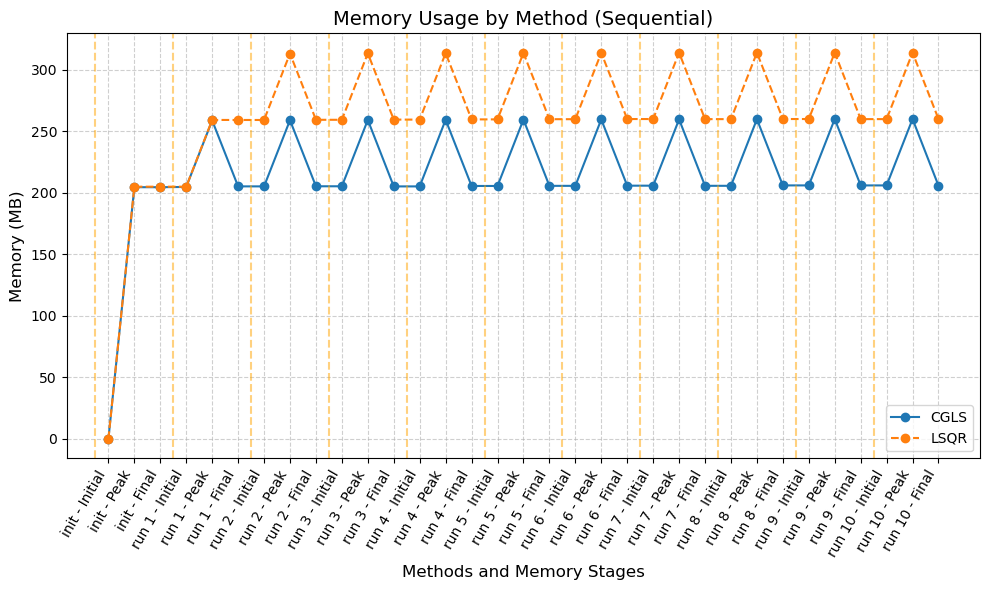

In [82]:
plot_mem(dfs=(cgls_lp, lsqr_lp), algNms=("CGLS", "LSQR"))

LSQR creates 4 copies of the ImageData space, and 2 copies of the AcquisitionData, totalling to ~**259 MB**. This can be seen clearly in the breakdown below:

In [51]:
%%capture lsqr_mem_prof
!python3 memory-sandstone.py lsqr_mp # Uncomment to run memory_profiler breakdown

In [ ]:
# Uncomment to see memory_profiler breakdown:
print(*lsqr_mem_prof.stdout.splitlines()[:42], sep="\n") # Print set_up
print(*lsqr_mem_prof.stdout.splitlines()[77:135], sep="\n") # Print run 1

Dataset folder already exists in .
Filename: /home/efv97572/forks/CIL-User-Showcase/015_Memory_Profiling_LSQR_CGLS/LSQRMP.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    92    653.9 MiB    653.9 MiB           1       @profile
    93                                             def set_up(self, initial, operator, data):
    94                                                 r'''Initialisation of the algorithm
    95                                                 Parameters
    96                                                 ------------
    97                                                 operator : Operator
    98                                                     Linear operator for the inverse problem
    99                                                 initial : (optional) DataContainer in the domain of the operator, default is a DataContainer filled with zeros. 
   100                                                     Initial guess 
   101           

### Tikhonov regularisation using CGLS and LSQR - with or without a block

#### Tikhonov regularisation

We can add a regularisation term to problem solved by CGLS; this gives us the minimisation problem in the following form, which is known as Tikhonov regularisation:
$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b \end{Vmatrix}^2_2 + \alpha^2\|u\|^2_2$$

where,

- $A$ is the projection operator

- $b$ is the acquired data

- $u$ is the unknown image to be solved for

- $\alpha$ is the regularisation parameter


The first term measures the fidelity of the solution to the data. The second term meausures the fidelity to the prior knowledge we have imposed on the system, operator $L$. $\alpha$ controls the trade-off between these terms. $L$ is often chosen to be a smoothing operator like the identity matrix, or a gradient operator **constrained to the squared L2-norm**.

This can be re-written equivalently in the block matrix form:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\binom{A}{\alpha I} u - \binom{b}{0}\end{Vmatrix}^2_2$$

With the definitions:

- $\tilde{A} = \binom{A}{\alpha I}$

- $\tilde{b} = \binom{b}{0}$

this can now be recognised as a least squares problem:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\tilde{A} u - \tilde{b}\end{Vmatrix}^2_2$$

and being a least squares problem, it can be solved using CGLS with $\tilde{A}$ as operator and $\tilde{b}$ as data.


Set up the algorithms:

In [ ]:
initial = ig.allocate(0)

L = IdentityOperator(ig)
alpha = 0.1

operator_block = BlockOperator(A, alpha*L)
zero_data = L.range.allocate(0)
data_block = BlockDataContainer(sandstone_noisy, zero_data)

sino_norm = Slicer(roi)(sandstone_cor).norm() # crop the 'perfect' sinogram
recon_norm = recon.norm() # 'perfect' reconstruction, already cropped

maxit = 100
itsAtATime = 1
N = round(maxit/itsAtATime)

xx = np.arange(0, maxit, itsAtATime)

In [ ]:
cgls_tik_block = CGLS(initial=initial, operator=operator_block, data=data_block, update_objective_interval = 10)
times_cgls_tik_block, rel_res_vec_cgls_tik_block, rel_err_vec_cgls_tik_block = timed_iterations(cgls_tik_block, N, itsAtATime)

lsqr_tik_block = LSQR(initial=initial, operator=operator_block, data=data_block, update_objective_interval = 10)
times_lsqr_tik_block, rel_res_vec_lsqr_tik_block, rel_err_vec_lsqr_tik_block = timed_iterations(lsqr_tik_block, N, itsAtATime)

lsqr_tik_simple = LSQR_Tikhonov(initial=initial, operator=A, data=sandstone_noisy, alpha = alpha)
times_lsqr_tik_simple, rel_res_vec_lsqr_tik_simple, rel_err_vec_lsqr_tik_simple = timed_iterations(lsqr_tik_simple, N, itsAtATime)

#### Convergence/reduction of residuals:

The plots below show the progress of the residuals across each iteration, and the error across iterations:

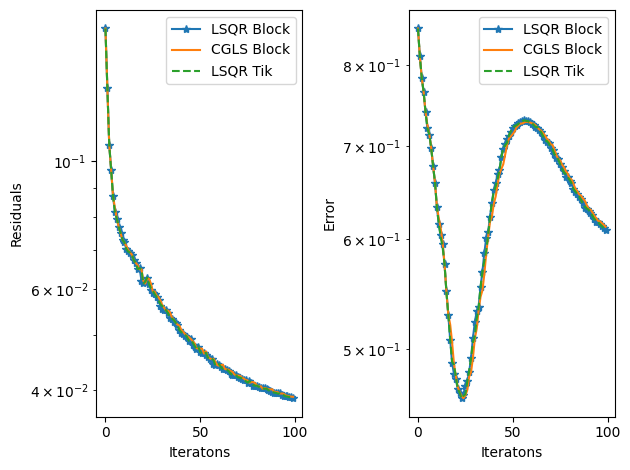

In [37]:
plt.subplot(1,2,1)
plt.semilogy(xx, rel_res_vec_lsqr_tik_block, '*-', xx, rel_res_vec_cgls_tik_block, '-', xx, rel_res_vec_lsqr_tik_simple, '--')
plt.xlabel('Iteratons') 
plt.ylabel('Residuals') 
plt.gca().legend(('LSQR Block', 'CGLS Block', 'LSQR Tik'))

plt.subplot(1,2,2)
plt.semilogy(xx, rel_err_vec_lsqr_tik_block, '*-', xx, rel_err_vec_cgls_tik_block, '-', xx, rel_err_vec_lsqr_tik_simple, '--')
plt.xlabel('Iteratons') 
plt.ylabel('Error') 
plt.gca().legend(('LSQR Block', 'CGLS Block', 'LSQR Tik'))
plt.tight_layout()

Comparing the time taken/elapsed across each iteration shows that LSQR Tik and CGLS Block are slightly faster in comparison to LSQR Block for 100 iterations, with CGLS Block being the fastest overall.

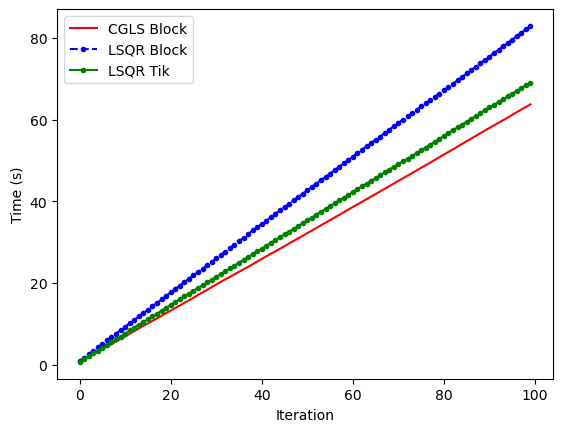

In [51]:
plt.plot(xx, times_cgls_tik_block, 'r-', xx, times_lsqr_tik_block, 'b.--', xx, times_lsqr_tik_simple, 'g.-' )
plt.xlabel('Iteration') 
plt.ylabel('Time (s)')
plt.gca().legend(('CGLS Block', 'LSQR Block', 'LSQR Tik'))

### Memory costs for LSQR+Block, CGLS+Block and LSQR+Tikhonov

#### Setting Up Memory Tracking:

Setup the memory tracking for the three algorithms:

In [135]:
%%capture cgls_block_prof
!python3 memory-sandstone.py cgls_lp_tik_block --track-peak

In [120]:
%%capture lsqr_block_prof
!python3 memory-sandstone.py lsqr_lp_tik_block --track-peak

In [121]:
%%capture lsqr_block_mp
!python3 memory-sandstone.py lsqr_mp_tik_block 

In [122]:
%%capture lsqr_tik_prof
!python3 memory-sandstone.py lsqr_tik_lp --track-peak

In [133]:
%%capture lsqr_tik_mp
!python3 memory-sandstone.py lsqr_tik_mp

#### Memory Usage Results: 

In [79]:
# ImageData and AcquisitionData Sizes
print(f"Estimate of 'initial' (ImageData) size: {initial.size*dtypeSize*MB}")
print(f"Estimate of 'sandstone_noisy' (AcquisitionData) size: {sandstone_noisy.size*dtypeSize*MB}")
print(f"Estimate of 'data_block' (Block AcquisitionData) size: {(sandstone_noisy.size+zero_data.size)*dtypeSize*MB}")

Estimate of 'initial' (ImageData) size: 53.9306640625
Estimate of 'sandstone_noisy' (AcquisitionData) size: 21.514892578125
Estimate of 'data_block' (Block AcquisitionData) size: 75.445556640625


In the setup for CGLS Block, the ImageData space is 53.9 MB but the (Block) AcquisitionData is now 75.4 MB.  
Since the algorithm is the same, we expect the same number of increases as before. In total, we expect a setup increase of:
(53.9 * 3) + (75.4 * 2) = **~312.5 MB**

In the dataframe below, there is a (temporary) peak increase of ~129.5 MB in the first `update` due to the line `self.operator.direct(self.p, out=self.q)`. This corresponds to the ImageData and Block AcquisitionData sizes: 53.9 + 75.4 = ~129.3 MB. 
Most of this memory is deallocated by the end of this line, ~21.5 MB (1x original AcquisitionData) stays occupied in the total usage. 

The subsequent `update` calls have a peak of ~107.9 MB, which is 1x AcqData (~21.5) less than the previous peak, suggesting that the AcqData buffer array in `self.q` is populated with values during the first call to `update`.

In total, CGLS Block makes:
* 3 copies of ImgData (53.9 MB)
* 2 copies of Block AcqData (75.4 MB)
* 1 copy of AcqData (21.5 MB)

The CGLS Block DataFrame shows these results below:

In [77]:
cgls_block_lp = line_peak_process(cgls_block_prof, norm=True)
cgls_block_lp.iloc[:12] # Truncate no. of rows

,Method,Initial Memory Usage (MiB),Peak Memory,Final Memory Usage (MiB),Total Memory Usage (MiB),Peak Memory Increase (MiB),Peak Line
0,init,0.00,312.64,312.64,312.64,312.64,"self.set_up(initial=initial, operator=operator..."
1,setup,0.02,312.64,312.64,312.62,312.62,self.q = self.operator.range_geometry().alloca...
2,run 1,312.64,442.28,334.69,22.05,129.64,update(self)
3,update 1,312.89,442.28,334.69,21.80,129.39,"self.operator.direct(self.p, out=self.q)"
4,run 2,334.69,442.58,334.85,0.16,107.89,update(self)
5,update 2,334.69,442.58,334.85,0.16,107.89,"self.operator.direct(self.p, out=self.q)"
6,run 3,334.85,442.81,335.10,0.25,107.96,update(self)
7,update 3,334.85,442.81,335.02,0.17,107.96,"self.operator.direct(self.p, out=self.q)"
8,run 4,335.10,442.97,335.18,0.08,107.87,update(self)
9,update 4,335.10,442.97,335.18,0.08,107.87,"self.operator.direct(self.p, out=self.q)"


We expect the same with LSQR block, in this case, 4 copies of ImageData and 2 copies of Block AcquisitionData, with an extra 21.5 MB allocated for the original AcquisitionData.
In `set_up`, the allocations are: (53.9 * 3) + 75.4 + 21.5 = **~258.6 MB**
in the first `update`, the allocations are: 53.9 + 75.4 = **~129.3 MB**

The memory increases in `update` 1 occur because the buffer arrays initialised in `set_up` become populated with values.

The peak of ~183 MB is due to `self.operator.direct(self.v, out=self.tmp_range)` creating temp buffers of ImgData + Block AcqData, and 
`self.operator.adjoint(self.u, out=self.tmp_domain)` creating 2 buffers of ImgData during `update` 1.

In total, LSQR Block makes:
* 4 copies of ImgData (53.9 MB)
* 2 copies of Block AcqData (75.4 MB)
* 1 copy of AcqData (21.5 MB)

In [124]:
lsqr_block_lp = line_peak_process(lsqr_block_prof, norm=True)
lsqr_block_lp.iloc[:12] # Truncate no. of rows

,Method,Initial Memory Usage (MiB),Peak Memory,Final Memory Usage (MiB),Total Memory Usage (MiB),Peak Memory Increase (MiB),Peak Line
0,init,0.00,259.04,259.04,259.04,259.04,"self.set_up(initial=initial, operator=operator..."
1,setup,0.00,259.04,259.04,259.04,259.04,self.tmp_range = data.geometry.allocate(None)
2,run 1,259.04,442.55,388.59,129.55,183.51,update(self)
3,update 1,259.17,442.55,388.59,129.42,183.38,"self.operator.adjoint(self.u, out=self.tmp_dom..."
4,run 2,388.59,496.70,388.78,0.19,108.11,update(self)
5,update 2,388.59,496.70,388.78,0.19,108.11,"self.operator.direct(self.v, out=self.tmp_range)"
6,run 3,388.78,496.89,388.97,0.19,108.11,update(self)
7,update 3,388.78,496.89,388.97,0.19,108.11,"self.operator.direct(self.v, out=self.tmp_range)"
8,run 4,388.97,497.07,389.16,0.19,108.10,update(self)
9,update 4,388.97,497.07,389.16,0.19,108.10,"self.operator.direct(self.v, out=self.tmp_range)"


In [111]:
# ImageData and AcquisitionData Sizes
print(f"Estimate of 'initial' (ImageData) size: {initial.size*dtypeSize*MB}")
print(f"Estimate of 'sandstone_noisy' (AcquisitionData) size: {sandstone_noisy.size*dtypeSize*MB}")

Estimate of 'initial' (ImageData) size: 53.9306640625
Estimate of 'sandstone_noisy' (AcquisitionData) size: 21.514892578125


The setup for LSQR Tikhonov does not use the Block operator, so the ImageData and AcquisitionData sizes are **53.9 MB** and **21.5 MB**, respectively.

We expect the Total Memory Usage to be the same as LSQR run previously, without the BlockOperator:
* 4 copies of ImageData (3 in `set_up`, 1 in `run`/`update`)
* 2 copies of AcquisitionData

Totalling to a usage of: (53.9 * 4) + (21.5 * 2) = **~258.6 MB**. This is shown in the outputs below, showing LSQR Tikhonov will use less memory than the block versions of CGLS and LSQR.

In [134]:
# Uncomment to see memory_profiler breakdown:
print(*lsqr_tik_mp.stdout.splitlines()[:49], sep="\n") # Print set_up
print(*lsqr_tik_mp.stdout.splitlines()[77:135], sep="\n") # Print run 1

Dataset folder already exists in .
Filename: /home/efv97572/forks/CIL-User-Showcase/015_Memory_Profiling_LSQR_CGLS/LSQRMP.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    92    652.9 MiB    652.9 MiB           1       @profile
    93                                             def set_up(self, initial, operator, data):
    94                                                 r'''Initialisation of the algorithm
    95                                                 Parameters
    96                                                 ------------
    97                                                 operator : Operator
    98                                                     Linear operator for the inverse problem
    99                                                 initial : (optional) DataContainer in the domain of the operator, default is a DataContainer filled with zeros. 
   100                                                     Initial guess 
   101           

We can see the increase of ~54 MB at the first iteration resulting from the line `self.operator.adjoint(self.u, out=self.tmp_domain)` which is also observed in the non-block version of LSQR:

In [104]:
print(*lsqr_tik_prof.stdout.splitlines()[117:241], sep="\n")

run 1
Start of run | Memory Usage: 857.60 MB | line:  
16 | Memory Usage: 857.60 MB | line: callbacks = [ProgressCallback(verbose=verbose)]
17 | Memory Usage: 857.60 MB | line: callback = kwargs.get('callback', None)
18 | Memory Usage: 857.60 MB | line: callbacks.append(_OldCallback(callback, verbose=verbose))
19 | Memory Usage: 857.60 MB | line: iterations = self.max_iteration
20 | Memory Usage: 857.60 MB | line: iterations+=1
21 | Memory Usage: 857.60 MB | line: self.max_iteration = self.iteration + iterations
22 | Memory Usage: 857.62 MB | line: iters = (count(self.iteration) if numpy.isposinf(self.max_iteration) else range(self.iteration, self.max_iteration))
23 | Memory Usage: 857.62 MB | line: update(self)
24 | Memory Usage: 857.73 MB | line: callback(self)
Start of update | Memory Usage: 857.73 MB | line:  

Memory Usage Log (Time, Memory in MB): 14:23:56.781811, 857.73 MB

Memory Usage Log (Time, Memory in MB): 14:23:56.817190, 911.54 MB

Memory Usage Log (Time, Memory in MB): 

In [137]:
lsqr_tik_lp = line_peak_process(lsqr_tik_prof, norm=True)
lsqr_tik_lp.iloc[:12] # Truncate no. of rows

,Method,Initial Memory Usage (MiB),Peak Memory,Final Memory Usage (MiB),Total Memory Usage (MiB),Peak Memory Increase (MiB),Peak Line
0,init,0.00,205.02,205.02,205.02,205.02,"self.set_up(initial=initial, operator=operator..."
1,setup,0.00,205.02,205.02,205.02,205.02,self.tmp_range = data.geometry.allocate(None)
2,run 1,205.02,259.24,259.18,54.16,54.22,update(self)
3,update 1,205.18,259.24,259.18,54.00,54.06,"self.x.sapyb(1, self.d, phi/rho, out=self.x)"
4,run 2,259.18,313.04,259.36,0.18,53.86,update(self)
5,update 2,259.18,313.04,259.36,0.18,53.86,"self.operator.direct(self.v, out=self.tmp_range)"
6,run 3,259.36,313.24,259.64,0.28,53.88,update(self)
7,update 3,259.36,313.24,259.64,0.28,53.88,"self.operator.direct(self.v, out=self.tmp_range)"
8,run 4,259.64,313.59,259.81,0.17,53.95,update(self)
9,update 4,259.64,313.59,259.81,0.17,53.95,"self.operator.direct(self.v, out=self.tmp_range)"


The graphs below show the memory usage trends across the method calls.    
LSQR Tikhonov has the lowest setup and peak memory usages of the algorithms, as the input data was smaller in size.

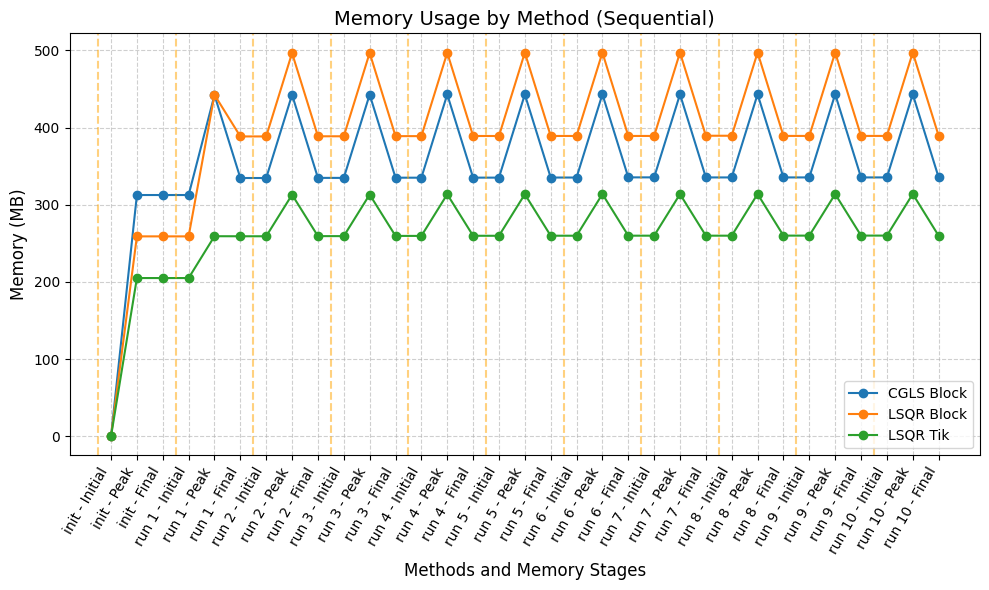

In [138]:
plot_mem(dfs=(cgls_block_lp, lsqr_block_lp, lsqr_tik_lp), algNms=("CGLS Block", "LSQR Block", "LSQR Tik"), linestyles=("-","-","-"))

### Comparisons of average iteration times (Unsure if keeping)

In [90]:
# Average time per iteration
avg_time_simple = [np.mean(np.diff(times_cgls, prepend=0)), np.mean(np.diff(times_lsqr, prepend=0))]

avg_time_tik = [np.mean(np.diff(times_cgls_tik_block, prepend=0)), np.mean(np.diff(times_lsqr_tik_block, prepend=0)), np.mean(np.diff(times_lsqr_tik_simple, prepend=0))]

The bar graphs below show the average time per iteration:

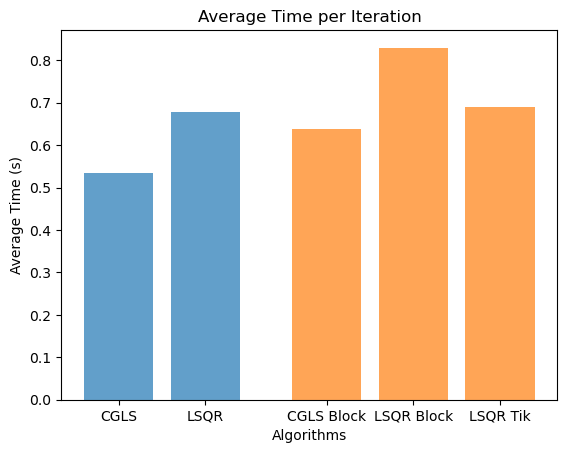

In [92]:
group1_x = np.arange(len(avg_time_simple))  # Positions
group2_x = np.arange(len(avg_time_tik)) + len(avg_time_simple) + 0.4 # Positions with a gap

# Plot bars
plt.bar(group1_x, avg_time_simple, alpha=0.7)
plt.bar(group2_x, avg_time_tik, alpha=0.7)

# Set x-ticks and labels
xticks_positions = np.concatenate([group1_x, group2_x])
xticks_labels = ['CGLS', 'LSQR'] + ['CGLS Block', 'LSQR Block', 'LSQR Tik']

plt.xticks(xticks_positions, xticks_labels)
plt.xlabel("Algorithms")
plt.ylabel("Average Time (s)")
plt.title("Average Time per Iteration")
plt.show()